# 4.1 prepare notebook

In [1]:
import sys
sys.path.append('../scripts/')
from ideal_robot import *

In [2]:
class Robot(IdealRobot):
    pass

<IPython.core.display.Javascript object>


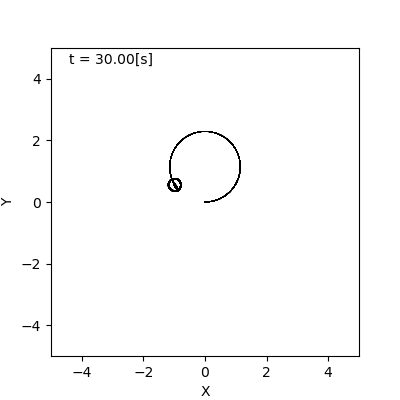

In [3]:
world = World(30, 0.1)

for i in range(100):
    circling = Agent(0.2, 10.0/180*math.pi)
    r = Robot(np.array([0,0,0]).T, sensor=None, agent=circling)
    world.append(r)
    
world.draw()

# 4.2 implement uncertainty

## 4.2.1 noise

In [4]:
import scipy.stats

In [5]:
class Robot(IdealRobot):
    def __init__(self, pose, agent=None, sensor=None, color='black', 
                 mean_distance_until_noise=1.0/5, theta_noise_std=math.pi/60,
                control_bias_rate_std=(0.1,0.1)): # pose=(x,y,theta)
        super().__init__(pose, agent, sensor, color)
        self.noise_pdf = scipy.stats.expon(scale=mean_distance_until_noise)
        self.distance_until_noise = self.noise_pdf.rvs() #rvs() means generate random variates.
        self.theta_noise = scipy.stats.norm(scale=theta_noise_std) #normal distribution with standard deviation=scale
        self.nu_bias_rate = scipy.stats.norm.rvs(loc=1.0, scale=control_bias_rate_std[0])
        self.omega_bias_rate = scipy.stats.norm.rvs(loc=1.0, scale=control_bias_rate_std[1])
        
    def add_noise(self, pose, nu, omega, time_interval):   
        # add control noise
        nu *= self.nu_bias_rate
        omega *= self.omega_bias_rate
        
        # add movement noise(only for angular)
        #check whether the robot hits noise
        self.distance_until_noise -= (abs(nu) + self.r*abs(omega)) * time_interval
        if(self.distance_until_noise) <= 0.0:
            # add new distance until noise.
            self.distance_until_noise += self.noise_pdf.rvs()
            # add angular noise when the robot hits noise.
            pose[2] += self.theta_noise.rvs()             
        return pose
    
    def one_step(self, time_interval):
        if not self.agent: return
        obs = self.sensor.data(self.pose) if self.sensor else None
        nu, omega = self.agent.decision(obs)
        self.pose = self.state_transition(nu, omega, time_interval, self.pose)
        self.pose = self.add_noise(self.pose, nu, omega, time_interval)

<IPython.core.display.Javascript object>


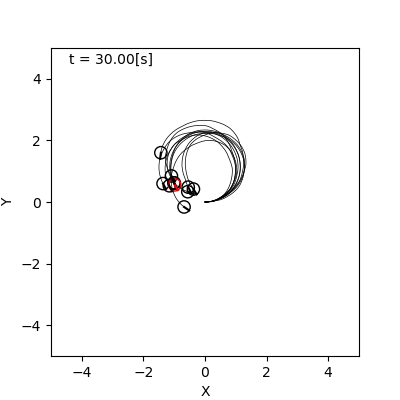

In [6]:
world = World(30, 0.1)

circling = Agent(0.2, 10.0/180*math.pi)

for i in range(10):
    r = Robot(np.array([0,0,0]), sensor=None, agent=circling)
    world.append(r)

ideal_robot = IdealRobot(np.array([0,0,0]), sensor=None, agent=circling, color='red')
world.append(ideal_robot)

world.draw()

## 4.2.3 stuck

In [12]:
class Robot(IdealRobot):
    def __init__(self, pose, agent=None, sensor=None, color='black', 
                 mean_distance_until_noise=1.0/5, theta_noise_std=math.pi/60,
                control_bias_rate_std=(0.1,0.1),
                mean_stuck_time=1e+1, mean_escape_time=1):
        super().__init__(pose, agent, sensor, color)
        self.noise_pdf = scipy.stats.expon(scale=mean_distance_until_noise)
        self.distance_until_noise = self.noise_pdf.rvs() #rvs() means generate random variates.
        self.theta_noise = scipy.stats.norm(scale=theta_noise_std) #normal distribution with standard deviation=scale
        #control noise
        self.nu_bias_rate = scipy.stats.norm.rvs(loc=1.0, scale=control_bias_rate_std[0])
        self.omega_bias_rate = scipy.stats.norm.rvs(loc=1.0, scale=control_bias_rate_std[1])
        #stuck
        self.stuck_pdf = scipy.stats.expon(scale=mean_stuck_time)
        self.time_until_stuck = self.stuck_pdf.rvs()
        self.escape_pdf = scipy.stats.expon(scale=mean_escape_time)
        self.time_until_escape = self.escape_pdf.rvs()
        self.is_stuck = False
        
    def add_noise(self, pose, nu, omega, time_interval):   
        # add control noise
        nu *= self.nu_bias_rate
        omega *= self.omega_bias_rate
        
        # add movement noise(only for angular)
        #check whether the robot hits noise
        self.distance_until_noise -= (abs(nu) + self.r*abs(omega)) * time_interval
        if(self.distance_until_noise) <= 0.0:
            # add new distance until noise.
            self.distance_until_noise += self.noise_pdf.rvs()
            # add angular noise when the robot hits noise.
            pose[2] += self.theta_noise.rvs()             
        return pose
    
    def stuck(self, nu, omega, time_interval): # returns updated speed (nu,omega).
        if self.is_stuck:
            self.time_until_escape -= time_interval
            if self.time_until_escape <= 0.0:
                self.time_until_escape += self.escape_pdf.rvs()
                self.is_stuck = False
        else:
            self.time_until_stuck -= time_interval
            if self.time_until_stuck <= 0.0:
                self.time_until_stuck += self.stuck_pdf.rvs()
                self.is_stuck = True
        #set control value 0 if the robot is stuck
        return nu*(not self.is_stuck), omega*(not self.is_stuck)
        
    def one_step(self, time_interval):
        if not self.agent: return
        obs = self.sensor.data(self.pose) if self.sensor else None
        nu, omega = self.agent.decision(obs)
        nu, omega = self.stuck(nu, omega, time_interval)
        self.pose = self.state_transition(nu, omega, time_interval, self.pose)
        self.pose = self.add_noise(self.pose, nu, omega, time_interval)

<IPython.core.display.Javascript object>


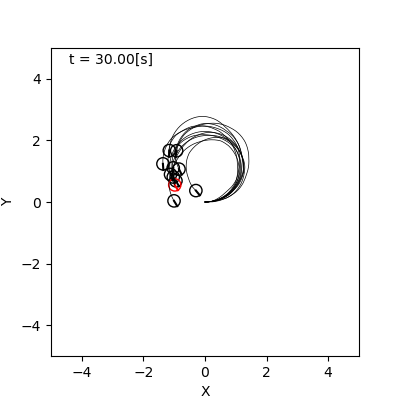

In [13]:
world = World(30, 0.1)

circling = Agent(0.2, 10.0/180*math.pi)

for i in range(10):
    r = Robot(np.array([0,0,0]), agent=circling)
    world.append(r)

ideal_robot = IdealRobot(np.array([0,0,0]), sensor=None, agent=circling, color='red')
world.append(ideal_robot)

world.draw()

## 4.2.4 kidnap

In [77]:
class Robot(IdealRobot):
    def __init__(self, pose, agent=None, sensor=None, color='gray', 
                 mean_distance_until_noise=1.0/5, theta_noise_std=math.pi/60,
                control_bias_rate_std=(0.1,0.1),
                mean_stuck_time=1e+1, mean_escape_time=1,
                mean_kidnap_time=1, kidnap_range_x=[[-5,5],[-5,5],[0,2*math.pi]]):
        super().__init__(pose, agent, sensor, color)
        self.noise_pdf = scipy.stats.expon(scale=mean_distance_until_noise)
        self.distance_until_noise = self.noise_pdf.rvs() #rvs() means generate random variates.
        self.theta_noise = scipy.stats.norm(scale=theta_noise_std) #normal distribution with standard deviation=scale
        #control noise
        self.nu_bias_rate = scipy.stats.norm.rvs(loc=1.0, scale=control_bias_rate_std[0])
        self.omega_bias_rate = scipy.stats.norm.rvs(loc=1.0, scale=control_bias_rate_std[1])
        #stuck
        self.stuck_pdf = scipy.stats.expon(scale=mean_stuck_time)
        self.time_until_stuck = self.stuck_pdf.rvs()
        self.escape_pdf = scipy.stats.expon(scale=mean_escape_time)
        self.time_until_escape = self.escape_pdf.rvs()
        self.is_stuck = False
        #kidnap
        self.kidnap_pdf = scipy.stats.expon(scale=mean_kidnap_time)
        self.time_until_kidnap = self.kidnap_pdf.rvs()
        self.kidnap_dist = scipy.stats.uniform(loc=(kidnap_range[0]),
                                               scale=(np.array(kidnap_range)[:,1]-np.array(kidnap_range)[:,0]))
        
    def add_noise(self, nu, omega, time_interval):   
        # add control noise
        nu *= self.nu_bias_rate
        omega *= self.omega_bias_rate
        
        # add movement noise(only for angular)
        #check whether the robot hits noise
        self.distance_until_noise -= (abs(nu) + self.r*abs(omega)) * time_interval
        if(self.distance_until_noise) <= 0.0:
            # add new distance until noise.
            self.distance_until_noise += self.noise_pdf.rvs()
            # add angular noise when the robot hits noise.
            self.pose[2] += self.theta_noise.rvs()             
    
    def stuck(self, nu, omega, time_interval):
        if self.is_stuck:
            self.time_until_escape -= time_interval
            if self.time_until_escape <= 0.0:
                self.time_until_escape += self.escape_pdf.rvs()
                self.is_stuck = False
        else:
            self.time_until_stuck -= time_interval
            if self.time_until_stuck <= 0.0:
                self.time_until_stuck += self.stuck_pdf.rvs()
                self.is_stuck = True
        #set control value 0 if the robot is stuck
        return nu*(not self.is_stuck), omega*(not self.is_stuck)
        
    def kidnap(self, time_interval):
        self.time_until_kidnap -= time_interval
        if self.time_until_kidnap < 0.0:
            self.time_until_kidnap += self.kidnap_pdf.rvs()
            self.pose = np.array(self.kidnap_dist.rvs())
            print("kidnapped to ",self.pose)
        
    def one_step(self, time_interval):
        if not self.agent: return
        obs = self.sensor.data(self.pose) if self.sensor else None
        nu, omega = self.agent.decision(obs)
        nu, omega = self.stuck(nu, omega, time_interval)
        self.pose = self.state_transition(nu, omega, time_interval, self.pose)
        self.add_noise(nu, omega, time_interval)
        self.kidnap(time_interval)

<IPython.core.display.Javascript object>


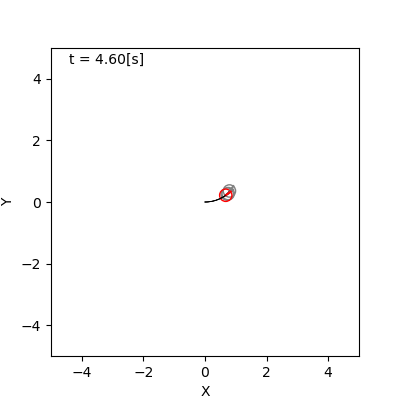

In [78]:
world = World(30, 0.1)

circling = Agent(0.2, 10.0/180*math.pi)

for i in range(3):
    r = Robot(np.array([0,0,0]), agent=circling)
    world.append(r)

ideal_robot = IdealRobot(np.array([0,0,0]), sensor=None, agent=circling, color='red')
world.append(ideal_robot)

world.draw()